In [1]:
from __future__ import print_function

import SimpleITK as sitk
from ipywidgets import interact, fixed
import itk
from itkwidgets import view

import numpy as np
import pandas as pd

import os
import gui
%matplotlib notebook

Mask가 있는 artery phase를 affine transform을 하고 artery phase의 마스크도 옮겨보자.

#### loading fixed and moving images

In [8]:
# read moving image (atlas) and fixed image
ct_basepath = '../../data'
moving_img_filename = os.path.join(ct_basepath, "ct_liver/artery/002_11007854_resize.hdr")
fixed_img_filename = os.path.join(ct_basepath, "ct_liver/portal/002_11007854_resize.hdr")

moving_img = sitk.ReadImage(moving_img_filename)
fixed_img = sitk.ReadImage(fixed_img_filename)

# SimpleITK registration supports only the pixel types sitkFloat32 and sitkFloat64
fixed_img = sitk.Cast(fixed_img, sitk.sitkInt16)
moving_img = sitk.Cast(moving_img, sitk.sitkInt16)

# rescale intensity for normalization
# fixed_img = sitk.RescaleIntensity(fixed_img)
# moving_img = sitk.RescaleIntensity(moving_img)

#### showing fixed moving images

<IPython.core.display.Javascript object>


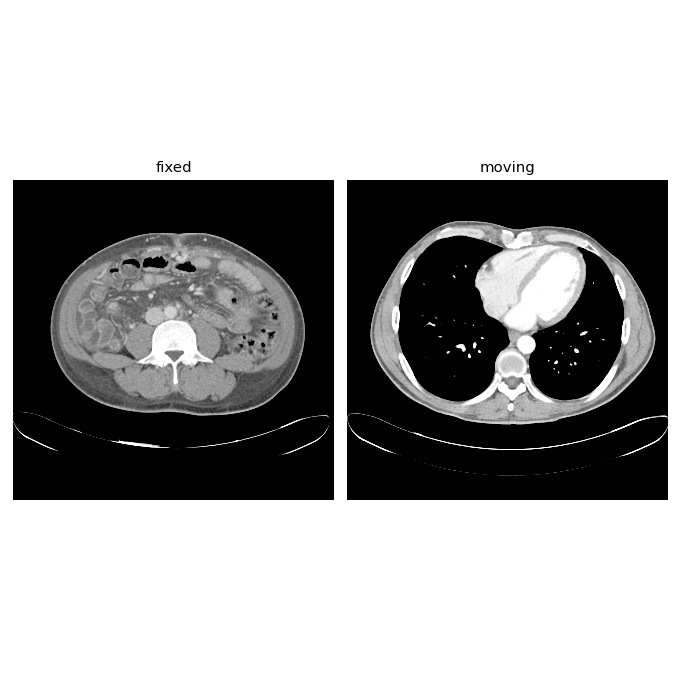

In [9]:
gui.MultiImageDisplay(image_list = [fixed_img, moving_img],                   
                      title_list = ['fixed', 'moving'], 
                     figure_size=(7.6, 7.6))
#                       figure_size=(8,4), 
#                       window_level_list=[ct_window_level, mr_window_level]);

#### loadind fixed and moving masks and cast mask images as sitk.sitkUInt8 type

In [12]:
# read moving image (atlas) and fixed image
moving_mask_filename = os.path.join(ct_basepath, "mask_liver/artery/002_11007854_resize_Lg.hdr")
fixed_mask_filename = os.path.join(ct_basepath, "mask_liver/portal/002_11007854_resize_Lg.hdr")

moving_mask = sitk.ReadImage(moving_mask_filename)
fixed_mask = sitk.ReadImage(fixed_mask_filename)

# SimpleITK registration supports only the pixel types sitkFloat32 and sitkFloat64
fixed_mask = sitk.Cast(fixed_mask, sitk.sitkUInt8)
moving_mask = sitk.Cast(moving_mask, sitk.sitkUInt8)

#### showing casted fixed and moving masks

<IPython.core.display.Javascript object>


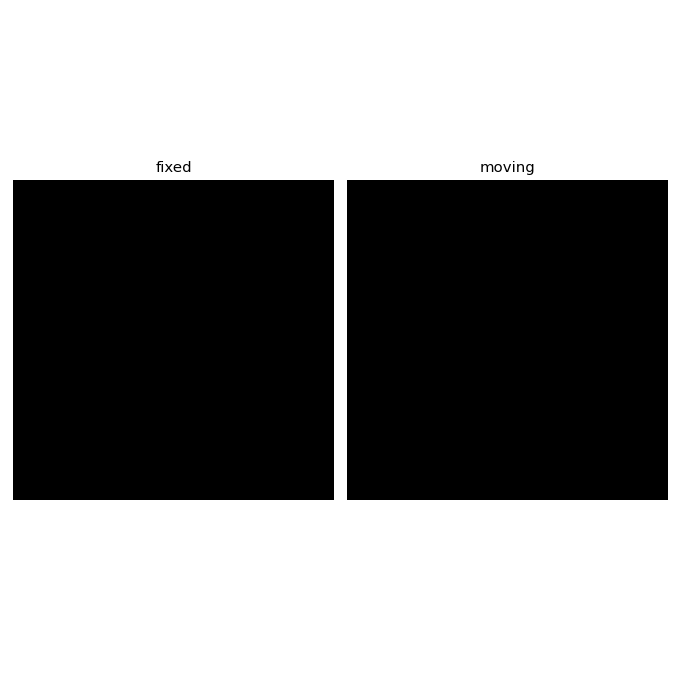

In [13]:
gui.MultiImageDisplay(image_list = [fixed_mask, moving_mask],                   
                      title_list = ['fixed', 'moving'], 
                     figure_size=(7.6, 7.6))

#### Affine registration with masks

In [14]:
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixed_img)
elastixImageFilter.SetMovingImage(moving_img)
elastixImageFilter.SetFixedMask(fixed_mask)
elastixImageFilter.SetMovingMask(moving_mask)

params = sitk.GetDefaultParameterMap('affine')
params['FixedInternalImagePixelType'] = ['int']
params['MovingInternalImagePixelType'] = ['int']
params['FixedImageDimension'] = ['3']
params['MovingImageDimension'] = ['3']
params['UseDirectionCosines'] = ['true']

################## Main Components #############################
params['Registration'] = ['MultiResolutionRegistration']
params['Interpolator'] =['BSplineInterpolator']
params['ResampleInterpolator'] = ['FinalBSplineInterpolator']
params['Resampler'] = ['DefaultResampler']

params['FixedImagePyramid'] = ['FixedRecursiveImagePyramid']
params['MovingImagePyramid'] = ['MovingRecursiveImagePyramid']

params['Optimizer'] = ['AdaptiveStochasticGradientDescent']
params['Transform'] = ['EulerTransform']
params['Metric'] = ['AdvancedMattesMutualInformation']

#################### Transformation ##########################

params['AutomaticScalesEstimation'] = ['true']
params['AutomaticTransformInitialization'] = ['true']
params['HowToCombineTransforms'] = ['Compose']

################### Similarity measure #####################

params['NumberOfHistogramBins'] = ['32']
params['ErodeMask'] = ['false']

#################### Multiresolution ######################

params['NumberOfResolutions'] = ['3']
params['ImagePyramidSchedule'] = ['4', '4', '4', '2', '2', '2', '1', '1', '1']

################### Optimizer ############################

params['MaximumNumberOfIterations'] = ['250']

# The step size of the optimizer, in mm. By default the voxel size is used.
# which usually works well. In case of unusual high-resolution images
# (eg histology) it is necessary to increase this value a bit, to the size
# of the "smallest visible structure" in the image:
# (MaximumStepLength 1.0)

################ Image sampling ######################

params['NumberOfSpatialSamples'] = ['10000']
params['NewSamplesEveryIteration'] = ['true']
params['ImageSampler'] = ['Random']

############# Interpolation and Resampling ##############

params['BSplineInterpolationOrder'] =['1']
params['FinalBSplineInterpolationOrder'] = ['1']
params['DefaultPixelValue'] =['0']
params['WriteResultImage'] = ['true']
params['ResultImagePixelType'] = ['int']
params['ResultImageFormat'] = ['mha']
params['CompressResultImage'] =['false']

elastixImageFilter.SetParameterMap(params)
#elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("affine"))
#elastixImageFilter.ReadParameterFile("../preprocessings/affine_params.txt")
elastixImageFilter.PrintParameterMap()
#
elastixImageFilter.Execute()
moving_img_affined = elastixImageFilter.GetResultImage()
#sitk.WriteImage(elastixImageFilter.GetResultImage(), "03_51391773a.mha")

RuntimeError: Exception thrown in SimpleITK ElastixImageFilter_Execute: /home/hahnyi/packages/SimpleElastix/Code/Elastix/src/sitkElastixImageFilterImpl.cxx:259:
sitk::ERROR: 
itk::ExceptionObject (0x5581f533dc30)
Location: "unknown" 
File: /home/hahnyi/packages/SimpleElastix/build/Elastix/Core/Main/elxElastixFilter.hxx
Line: 253
Description: itk::ERROR: ElastixFilter(0x7fb5f8019f90): Internal elastix error: See elastix log (use LogToConsoleOn() or LogToFileOn()).



#### show moving to fixed images after registration 

In [7]:
gui.MultiImageDisplay(image_list = [fixed_img, elastixImageFilter.GetResultImage()],                   
                      title_list = ['fixed', 'm2f_a'], 
                     figure_size=(7.6, 7.6))

<IPython.core.display.Javascript object>

#### transfomix moving mask to fixed mask according to previous registration parameterMap

In [13]:
transformParameterMap = elastixImageFilter.GetTransformParameterMap()
transformixImageFilter = sitk.TransformixImageFilter()
transformixImageFilter.SetTransformParameterMap(transformParameterMap)
transformixImageFilter.SetMovingImage(moving_mask)
transformixImageFilter.Execute()
sitk.WriteImage(transformixImageFilter.GetResultImage(), "m2f_a_mask.mha")

In [9]:
def set_mask_value(image, mask, value):
    msk32 = sitk.Cast(mask, sitk.sitkFloat32)
    return sitk.Cast(sitk.Cast(image, sitk.sitkFloat32) *
                     sitk.InvertIntensity(msk32, maximum=1.0) + 
                     msk32*value, image.GetPixelID())

In [17]:
tmp = set_mask_value(transformixImageFilter.GetResultImage(),
                     transformixImageFilter.GetResultImage()>=0.3, 1)
moving_mask_affined = sitk.Cast(set_mask_value(tmp, tmp<0.3, 0), sitk.sitkUInt8)

sitk.WriteImage(moving_mask_affined, "m2f_a_mask.mha")

<IPython.core.display.Javascript object>


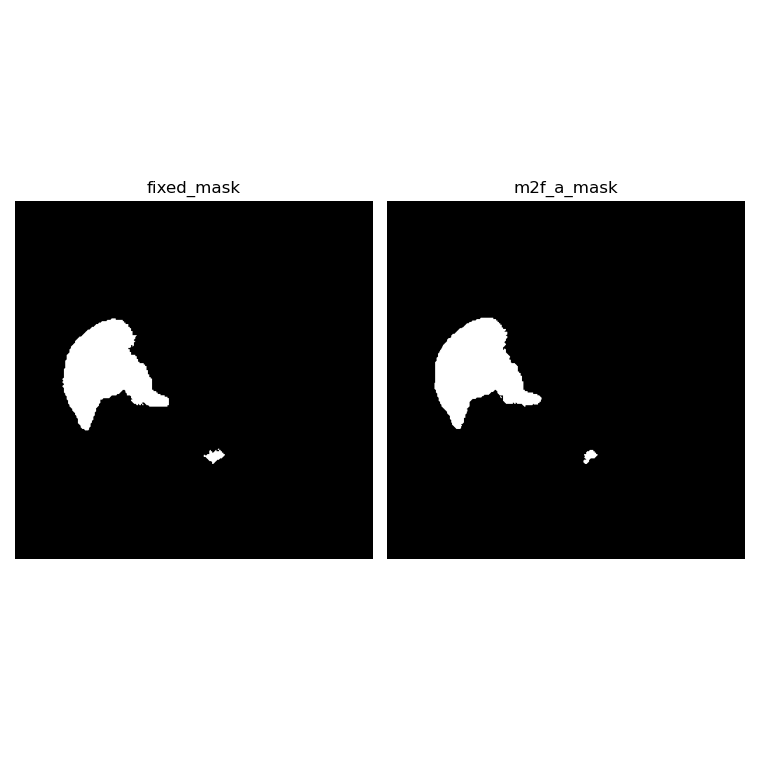

In [18]:
gui.MultiImageDisplay(image_list = [fixed_mask, moving_mask_affined],                   
                      title_list = ['fixed_mask', 'm2f_a_mask'], 
                     figure_size=(7.6, 7.6))

#### Bspline registration

#### Both image and mask must have same spacing.

In [28]:
print(fixed_img.GetSpacing())
print(fixed_mask.GetSpacing())
print(moving_img_affined.GetSpacing())
moving_mask_affined.SetSpacing([0.7148439884185791, 0.7148439884185791, 5.0])
print(moving_mask_affined.GetSpacing())

(0.7148439884185791, 0.7148439884185791, 5.0)
(0.7148439884185791, 0.7148439884185791, 5.0)
(0.7148439884185791, 0.7148439884185791, 5.0)
(0.7148439884185791, 0.7148439884185791, 5.0)


In [29]:
elastixImageFilter.SetFixedImage(fixed_img)
elastixImageFilter.SetMovingImage(moving_img_affined)
elastixImageFilter.SetFixedMask(fixed_mask)
elastixImageFilter.SetMovingMask(moving_mask_affined)
#elastixImageFilter.ReadParameterFile("../preprocessings/bspline_params.txt")

params = sitk.GetDefaultParameterMap('bspline')
params['FixedInternalImagePixelType'] = ['int']
params['MovingInternalImagePixelType'] = ['int']
params['FixedImageDimension'] = ['3']
params['MovingImageDimension'] = ['3']
params['UseDirectionCosines'] = ['true']

################## Main Components #############################
params['Registration'] = ['MultiResolutionRegistration']
params['Interpolator'] =['BSplineInterpolator']
params['ResampleInterpolator'] = ['FinalBSplineInterpolator']
params['Resampler'] = ['DefaultResampler']

params['FixedImagePyramid'] = ['FixedRecursiveImagePyramid']
params['MovingImagePyramid'] = ['MovingRecursiveImagePyramid']

params['Optimizer'] = ['AdaptiveStochasticGradientDescent']
params['Transform'] = ['BSplineTransform']
params['Metric'] = ['AdvancedMattesMutualInformation']

#################### Transformation ############################
params['GridSpacingSchedule'] = ['4', '4', '4', '2', '2', '2', '1', '1', '1']
#params['FinalGridSpacingInPhysicalUnits'] =['40']
params['HowToCombineTransforms'] = ['Compose']

#################### Similarity measure ########################
params['NumberOfHistogramBins'] =['32']
#params['ErodeMask'] = ['false']

#################### Multiresolution ######################

params['NumberOfResolutions'] = ['3']
params['ImagePyramidSchedule'] = ['4', '4', '4', '2', '2', '2', '1', '1', '1']

################### Optimizer ############################

params['MaximumNumberOfIterations'] = ['500']

################ Image sampling ######################

params['NumberOfSpatialSamples'] = ['10000']
params['NewSamplesEveryIteration'] = ['true']
params['ImageSampler'] = ['Random']

############# Interpolation and Resampling ##############

params['BSplineInterpolationOrder'] =['3']
params['FinalBSplineInterpolationOrder'] = ['3']
params['DefaultPixelValue'] =['0']
params['WriteResultImage'] = ['true']
params['ResultImagePixelType'] = ['int']
params['ResultImageFormat'] = ['mha']
params['CompressResultImage'] =['int']

elastixImageFilter.SetParameterMap(params)
elastixImageFilter.PrintParameterMap()

elastixImageFilter.Execute()
#sitk.WriteImage(elastixImageFilter.GetResultImage(), "03_51391773ab.mha")

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f5ea42f9f30> >

<IPython.core.display.Javascript object>


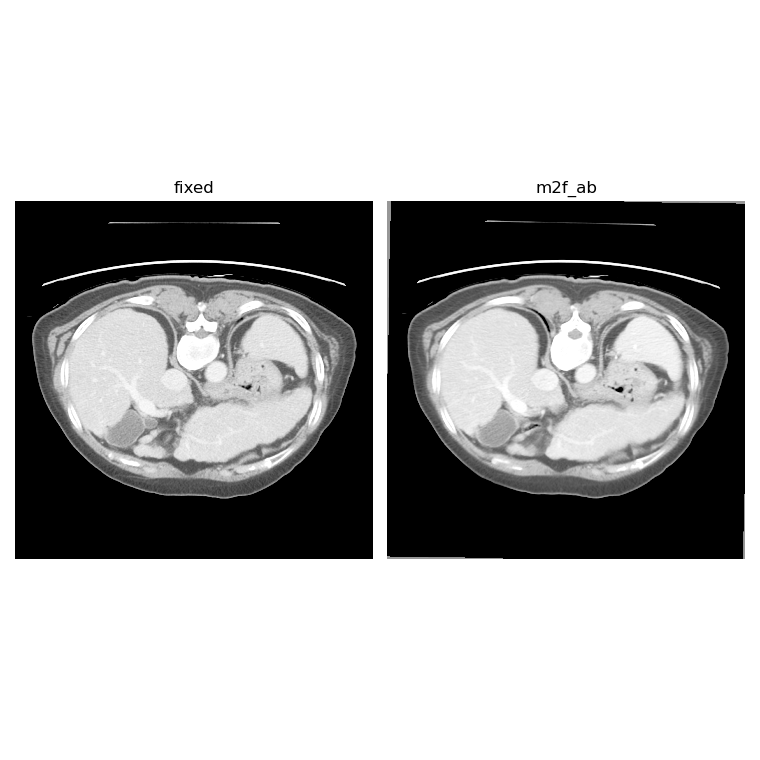

In [30]:
gui.MultiImageDisplay(image_list = [fixed_img, elastixImageFilter.GetResultImage()],                   
                      title_list = ['fixed', 'm2f_ab'], 
                     figure_size=(7.6, 7.6))

#### loadind fixed and moving masks and cast mask images as sitk.sitkUInt8 type

In [31]:
transformParameterMap = elastixImageFilter.GetTransformParameterMap()
transformixImageFilter = sitk.TransformixImageFilter()
transformixImageFilter.SetTransformParameterMap(transformParameterMap)
transformixImageFilter.SetMovingImage(moving_mask_affined)
transformixImageFilter.Execute()
sitk.WriteImage(transformixImageFilter.GetResultImage(), "m2f_ab_mask.mha")

In [32]:
tmp = set_mask_value(transformixImageFilter.GetResultImage(),
                     transformixImageFilter.GetResultImage()>=0.3, 1)
moving_mask_bsplined = sitk.Cast(set_mask_value(tmp, tmp<0.3, 0), sitk.sitkUInt8)

sitk.WriteImage(moving_mask_bsplined, "m2f_ab_mask.mha")

<IPython.core.display.Javascript object>


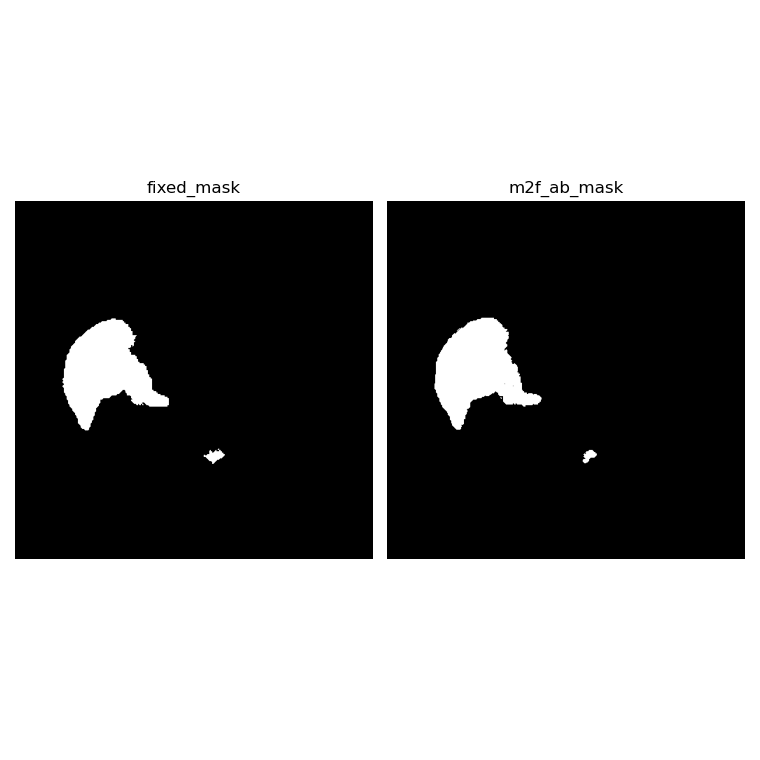

In [33]:
gui.MultiImageDisplay(image_list = [fixed_mask, moving_mask_bsplined],                   
                      title_list = ['fixed_mask', 'm2f_ab_mask'], 
                     figure_size=(7.6, 7.6))